In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [2]:
import wfdb
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter

WINDOW_SEC = 2
TESTID_CLASSES = {'N', 'V', 'F'}
LABEL_MAP = lambda l: 0 if l == 'N' else 1

RECORDS = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

def download_record(name, duration_sec=600):
    try:
        rec = wfdb.rdrecord(name, pn_dir='mitdb')
        ann = wfdb.rdann(name, 'atr', pn_dir='mitdb')
    except Exception as e:
        print(f"[ERROR] Failed to load record {name}: {e}")
        return None, None, None

    fs = rec.fs
    signal = rec.p_signal
    max_len = int(fs * duration_sec)

    signal = signal[:max_len]
    valid_idx = ann.sample < max_len
    ann.sample = ann.sample[valid_idx]
    ann.symbol = np.array(ann.symbol)[valid_idx].tolist()

    return signal, ann, fs

def segment_beats(signal, ann, fs, window_sec=2.0):
    half_window = int(fs * window_sec / 2)
    beats, labels = [], []

    for sample, label in zip(ann.sample, ann.symbol):
        if label not in TESTID_CLASSES:
            continue

        start, end = sample - half_window, sample + half_window
        if start < 0 or end > len(signal):
            continue

        segment = signal[start:end, 0]
        segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
        beats.append(segment)
        labels.append(LABEL_MAP(label))

    return beats, labels

random.seed(42)
random.shuffle(RECORDS)
split_idx = int(0.8 * len(RECORDS))
train_recs = RECORDS[:split_idx]
test_recs = RECORDS[split_idx:]

def process_records(record_list):
    all_beats, all_labels = [], []
    for rec in record_list:
        signal, ann, fs = download_record(rec)
        if signal is None:
            continue
        segments, labels = segment_beats(signal, ann, fs, window_sec=WINDOW_SEC)
        all_beats.extend(segments)
        all_labels.extend(labels)
    return np.array(all_beats), np.array(all_labels)

X_train, y_train = process_records(train_recs)
X_test, y_test = process_records(test_recs)

X_train = X_train[:, np.newaxis, :]
X_test = X_test[:, np.newaxis, :]

print(f"[INFO] Train: {len(X_train)} beats (Normal: {np.sum(y_train==0)}, Abnormal: {np.sum(y_train==1)})")
print(f"[INFO] Test:  {len(X_test)} beats (Normal: {np.sum(y_test==0)}, Abnormal: {np.sum(y_test==1)})")
print("[INFO] Train Class Ratio:", Counter(y_train))
print("[INFO] Test Class Ratio:", Counter(y_test))

def plot_example(class_idx=1):
    example = X_train[y_train == class_idx][0][0]
    plt.plot(example)
    plt.title("Abnormal" if class_idx == 1 else "Normal")
    plt.grid(True)
    plt.show()


[INFO] Train: 22747 beats (Normal: 20386, Abnormal: 2361)
[INFO] Test:  4926 beats (Normal: 4696, Abnormal: 230)
[INFO] Train Class Ratio: Counter({np.int64(0): 20386, np.int64(1): 2361})
[INFO] Test Class Ratio: Counter({np.int64(0): 4696, np.int64(1): 230})


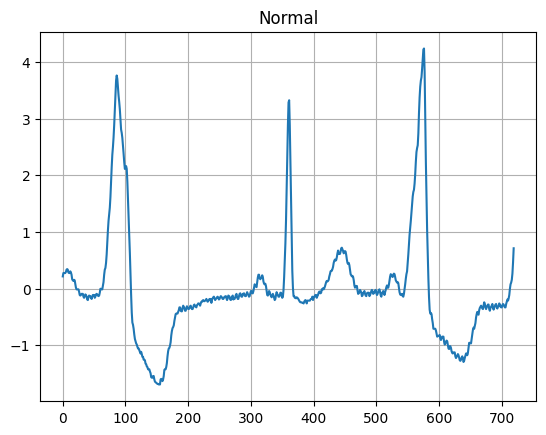

In [3]:
plot_example(class_idx=0)

In [4]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

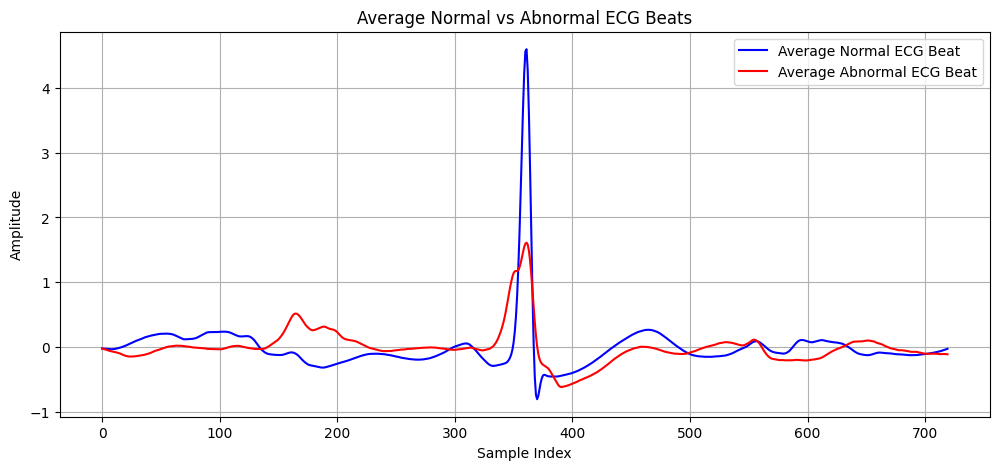

In [5]:
import matplotlib.pyplot as plt
import numpy as np

normal_beats = X[y == 0]
abnormal_beats = X[y == 1]

avg_normal = np.mean(normal_beats[:, 0, :], axis=0)
avg_abnormal = np.mean(abnormal_beats[:, 0, :], axis=0)

plt.figure(figsize=(12, 5))
plt.plot(avg_normal, label='Average Normal ECG Beat', color='blue')
plt.plot(avg_abnormal, label='Average Abnormal ECG Beat', color='red')
plt.title('Average Normal vs Abnormal ECG Beats')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, max(channels // reduction, 1), bias=False)
        self.fc2 = nn.Linear(max(channels // reduction, 1), channels, bias=False)

    def forward(self, x):
        # x: [B, C, L]
        b, c, _ = x.size()
        y = F.adaptive_avg_pool1d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1)
        return x * y.expand_as(x)

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1, downsample=None, dropout=0.2):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class Net(nn.Module):
    """
    Integrated ECG model:
      - Stacked ResidualBlock1D encoder with SE
      - Temporal Multi-Head Attention (batch_first)
      - Global pooling + classifier
    """
    def __init__(self,
                 input_channels=1,
                 num_classes=1,
                 block_channels=(64, 128, 256),
                 kernel_sizes=(7,5,3),
                 strides=(2,2,2),
                 attention_heads=4,
                 transformer_dropout=0.2,
                 encoder_dropout=0.2,
                 classifier_dropout=0.3):
        super().__init__()

        assert len(block_channels) == len(kernel_sizes) == len(strides), "block configs must match"

        # initial conv (keeps things stable)
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, block_channels[0], kernel_size=kernel_sizes[0], stride=1,
                      padding=kernel_sizes[0]//2, bias=False),
            nn.BatchNorm1d(block_channels[0]),
            nn.ReLU(inplace=True)
        )

        # build residual stack
        layers = []
        in_ch = block_channels[0]
        for i, out_ch in enumerate(block_channels):
            k = kernel_sizes[i]
            s = strides[i]
            if in_ch != out_ch or s != 1:
                downsample = nn.Sequential(
                    nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=s, bias=False),
                    nn.BatchNorm1d(out_ch)
                )
            else:
                downsample = None
            layers.append(ResidualBlock1D(in_channels=in_ch, out_channels=out_ch,
                                          kernel_size=k, stride=s, downsample=downsample, dropout=encoder_dropout))
            in_ch = out_ch
        self.encoder = nn.Sequential(*layers)

        # attention expects embed_dim == last channel size
        self.embed_dim = block_channels[-1]
        self.attention = nn.MultiheadAttention(embed_dim=self.embed_dim,
                                               num_heads=attention_heads,
                                               dropout=transformer_dropout,
                                               batch_first=True)

        # small feed-forward after attention (residual)
        self.attn_ff = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(transformer_dropout),
            nn.Linear(self.embed_dim, self.embed_dim)
        )
        self.attn_norm = nn.LayerNorm(self.embed_dim)

        # classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(classifier_dropout),
            nn.Linear(self.embed_dim // 2, num_classes)
        )

        # init weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, (nn.Linear, nn.Conv1d)):
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (B, C, L)
        x = self.stem(x)               # -> (B, block_channels[0], L)
        x = self.encoder(x)           # -> (B, embed_dim, L')

        # prepare for attention: (B, Seq, Features)
        x_seq = x.permute(0, 2, 1)    # (B, L', embed_dim)

        # self-attention + residual
        attn_out, _ = self.attention(x_seq, x_seq, x_seq)  # (B, L', embed_dim)
        x_seq = x_seq + attn_out
        # FFN + norm
        ff = self.attn_ff(x_seq)
        x_seq = self.attn_norm(x_seq + ff)

        # back to (B, embed_dim, L')
        x = x_seq.permute(0, 2, 1)

        # global pooling + classifier
        pooled = self.global_pool(x).squeeze(-1)  # (B, embed_dim)
        out = self.classifier(pooled)             # (B, num_classes)
        return out


In [7]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import torch.nn.functional as F
import torch.nn as nn


class RandApply:
    def __init__(self, aug_fn, p=0.5):
        self.aug_fn = aug_fn
        self.p = p

    def __call__(self, signal, severity=0.5):
        if np.random.rand() < self.p:
            return self.aug_fn(signal, severity=severity)
        return signal


class Shift:
    def __init__(self, max_shift_ratio=0.05):
        self.max_shift_ratio = max_shift_ratio

    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        max_shift = max(1, int(self.max_shift_ratio * length))
        shift = np.random.randint(-max_shift, max_shift + 1)
        return np.roll(signal, shift)


class Noise:
    def __init__(self, base_std=0.05):
        self.base_std = base_std

    def __call__(self, signal, severity=0.5):
        noise_std = self.base_std * severity
        noise = np.random.normal(0, noise_std, signal.shape)
        noise = gaussian_filter1d(noise, sigma=np.random.uniform(0.5, 3.0))
        return signal + noise


class Wander:
    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        t = np.linspace(0, 1, length)
        freq = np.random.uniform(0.01, 0.06)
        amplitude = np.random.uniform(0.02, 0.2) * severity
        wander = amplitude * np.sin(2 * np.pi * freq * t)
        offset = np.random.uniform(-0.05, 0.05) * severity
        return signal + wander + offset


class DropoutChunk:
    def __init__(self, min_ratio=0.02, max_ratio=0.15):
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio

    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        num_chunks = max(1, int(1 + 2 * severity))
        augmented = signal.copy()
        for _ in range(np.random.randint(1, num_chunks + 1)):
            dropout_len = np.random.randint(
                max(1, int(self.min_ratio * length)),
                max(2, int(self.max_ratio * length)),
            )
            start = np.random.randint(0, max(1, length - dropout_len))
            augmented[start : start + dropout_len] = 0.0
        return augmented


class Spikes:
    def __init__(self, max_spike_len=9):
        self.max_spike_len = max_spike_len

    def __call__(self, signal, severity=0.1):
        augmented = signal.copy()
        length = len(augmented)

        if length <= 1:
            return augmented

        spike_len = max(1, int(self.max_spike_len * severity))
        spike_len = min(spike_len, length)
        spike = np.random.uniform(-1, 1, size=spike_len)

        start = np.random.randint(0, length - spike_len + 1)
        augmented[start : start + spike_len] += spike
        return augmented


class Warp:
    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        num_knots = max(2, int(3 + 3 * severity))
        warp_strength = 0.06 * severity

        orig_x = np.linspace(0, 1, length)
        knot_x = np.linspace(0, 1, num_knots)
        displacement = np.random.uniform(-warp_strength, warp_strength, size=num_knots)
        knot_y = np.clip(knot_x + displacement, 0, 1)
        warped_x = np.interp(orig_x, knot_x, knot_y) * (length - 1)

        sig_1d = signal.flatten()

        sorted_indices = np.argsort(warped_x)
        warped_x_sorted = warped_x[sorted_indices]
        sig_sorted = sig_1d[sorted_indices]

        warped_signal = np.interp(np.arange(length), warped_x_sorted, sig_sorted)

        return warped_signal


class BaselineDrift:
    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        t = np.linspace(0, 1, length)
        num_drifts = max(1, int(1 + severity * 2))
        baseline_drift = np.zeros_like(t)
        for _ in range(np.random.randint(1, num_drifts + 1)):
            freq = np.random.uniform(0.002, 0.03)
            amp = np.random.uniform(0.02, 0.2) * severity
            phase = np.random.uniform(0, 2 * np.pi)
            baseline_drift += amp * np.sin(2 * np.pi * freq * t + phase)
        return signal + baseline_drift


class LineNoise:
    def __init__(self, fs=360):
        self.fs = fs

    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        t = np.arange(length) / float(self.fs)
        line_amp = 0.02 * severity
        line_noise = line_amp * np.sin(2 * np.pi * 60 * t)
        return signal + line_noise


class Scale:
    def __call__(self, signal, severity=0.5):
        scale = np.random.uniform(1 - 0.2 * severity, 1 + 0.2 * severity)
        return signal * scale


class Steps:
    def __call__(self, signal, severity=0.5):
        length = signal.shape[-1]
        num_steps = max(1, int(1 + severity))
        augmented = signal.copy()
        for _ in range(np.random.randint(1, num_steps + 1)):
            step_pos = np.random.randint(0, max(1, length - 20))
            step_val = np.random.uniform(-0.2, 0.2) * severity
            augmented[step_pos:] += step_val
        return augmented


class ComposeAugmentations:
    def __init__(self, aug_list):
        self.aug_items = []
        for item in aug_list:
            if isinstance(item, tuple):
                fn, p = item
                self.aug_items.append(RandApply(fn, p))
            else:
                self.aug_items.append(RandApply(item, p=1.0))

    def __call__(self, signal, severity=0.5):
        augmented = signal.copy()
        for aug in self.aug_items:
            augmented = aug(augmented, severity=severity)
        return np.clip(augmented, -5, 5)


augment_fn = ComposeAugmentations(
    [
        (Shift(), 0.8),
        (Noise(), 0.9),
        (BaselineDrift(), 0.6),
        (DropoutChunk(), 0.4),
        (Spikes(), 0.25),
        (Warp(), 0.2),
        (LineNoise(fs=360), 0.2),
        (Scale(), 0.4),
        (Steps(), 0.2),
    ]
)

def create_weighted_sampler(labels):
    labels = np.array(labels)
    classes = np.unique(labels)
    class_counts = np.array([np.sum(labels == c) for c in classes])
    weights_per_class = {c: 1.0 / count for c, count in zip(classes, class_counts)}
    weights = np.array([weights_per_class[l] for l in labels], dtype=np.float32)
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
    return sampler


def crop_signal(signal, crop_len=250):
    L = signal.shape[-1]
    if crop_len > L:
        raise ValueError(f"crop_len ({crop_len}) can't be longer than signal length ({L})")
    start = np.random.randint(0, L - crop_len + 1)
    return signal[..., start : start + crop_len]


class AugmentedECGDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        augment_fn=None,
        augment_all=False,
        crop_len=250,
        severity=0.0,
        class_conditional_aug=False,
    ):
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.augment_fn = augment_fn
        self.augment_all = augment_all
        self.crop_len = crop_len

        self.severity = None if severity is None else float(severity) if not isinstance(severity, tuple) else tuple(severity)

        self.class_conditional_aug = class_conditional_aug

    def set_severity(self, severity):
        if severity is None:
            self.severity = None
        elif isinstance(severity, tuple):
            self.severity = tuple(severity)
        else:
            self.severity = float(severity)

    def _sample_severity(self):
        # If fixed float -> use it
        if isinstance(self.severity, float):
            return self.severity
        # If tuple -> uniform between range
        if isinstance(self.severity, tuple):
            return float(np.random.uniform(self.severity[0], self.severity[1]))
        # If None -> mix easy/med/hard probabilities (you can tweak)
        # easy ~ 0.05, med ~0.15, hard ~ 0.30 (these are examples)
        r = np.random.rand()
        if r < 0.6:
            return float(np.random.uniform(0.02, 0.10))   # easy
        elif r < 0.9:
            return float(np.random.uniform(0.10, 0.20))   # medium
        else:
            return float(np.random.uniform(0.20, 0.35))   # hard

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx]
        label = int(self.y[idx])

        if signal.shape[-1] < self.crop_len:
            pad_len = self.crop_len - signal.shape[-1]
            signal = np.pad(signal, ((0, 0), (0, pad_len)) if signal.ndim == 2 else (0, pad_len), mode="constant")

        signal = crop_signal(signal, crop_len=self.crop_len)

        if self.augment_all and self.augment_fn:
            sev = self._sample_severity()
            if self.class_conditional_aug:
                if label == 1:
                    signal = self.augment_fn(signal.squeeze(), severity=sev)
                    signal = np.expand_dims(signal, axis=0)
            else:
                signal = self.augment_fn(signal.squeeze(), severity=sev)
                signal = np.expand_dims(signal, axis=0)

        return torch.from_numpy(signal.astype(np.float32)), torch.tensor(label, dtype=torch.long)


def prepare_loaders(
    X,
    y,
    augment_fn=augment_fn,
    batch_size=64,
    crop_len=250,
    class_conditional_aug=False,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=42,
):
    X = np.asarray(X)
    y = np.asarray(y)

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_ratio, stratify=y, random_state=random_state
    )

    val_fraction_of_remaining = val_ratio / (1.0 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_fraction_of_remaining, stratify=y_train_val, random_state=random_state
    )

    train_dataset = AugmentedECGDataset(
        X_train,
        y_train,
        augment_fn=augment_fn,
        augment_all=True,
        crop_len=crop_len,
        severity=0.0,
        class_conditional_aug=class_conditional_aug,
    )
    val_dataset = AugmentedECGDataset(X_val, y_val, augment_fn=None, augment_all=False, crop_len=crop_len)
    test_dataset = AugmentedECGDataset(X_test, y_test, augment_fn=None, augment_all=False, crop_len=crop_len)

    sampler = create_weighted_sampler(y_train)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, y_train, y_test, train_dataset


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import math
from torch.optim.lr_scheduler import _LRScheduler

# Cosine LR with warmup
class CosineWarmupLR(_LRScheduler):
    def __init__(self, optimizer, num_warmup_epochs, num_training_epochs, base_lr, last_epoch=-1):
        self.num_warmup_epochs = num_warmup_epochs
        self.num_training_epochs = num_training_epochs
        self.base_lr = base_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        epoch = self.last_epoch + 1
        if epoch <= self.num_warmup_epochs:
            return [self.base_lr * epoch / self.num_warmup_epochs for _ in self.optimizer.param_groups]
        else:
            progress = (epoch - self.num_warmup_epochs) / max(1, self.num_training_epochs - self.num_warmup_epochs)
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return [self.base_lr * cosine_decay for _ in self.optimizer.param_groups]

class BCEWeightedLoss(nn.Module):
    def __init__(self, pos_weight=1.0):
        super().__init__()
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        weight_tensor = torch.tensor(self.pos_weight, device=logits.device)
        loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=weight_tensor, reduction='none'
        )

        return loss.mean()


def hard_negative_mining(logits, targets, neg_ratio=3.0):
    probs = torch.sigmoid(logits)
    pos_mask = targets == 1
    neg_mask = targets == 0
    num_pos = pos_mask.sum().item()
    num_neg_total = neg_mask.sum().item()
    num_neg_keep = min(int(num_pos * neg_ratio), num_neg_total)

    if num_neg_total == 0 or num_neg_keep == 0:
        return logits, targets

    neg_scores = probs[neg_mask]
    if num_neg_keep >= len(neg_scores):
        keep_neg_mask = neg_mask
    else:
        topk_idx = torch.topk(neg_scores, k=num_neg_keep).indices
        keep_neg_mask = torch.zeros_like(neg_mask, dtype=torch.bool)
        neg_indices = torch.nonzero(neg_mask, as_tuple=False).squeeze(1)
        keep_neg_mask[neg_indices[topk_idx]] = True

    final_mask = pos_mask | keep_neg_mask
    return logits[final_mask], targets[final_mask]

# Dataset-level sampler update
def update_sampler(model, dataset, base_weights, device, factor=2.0, n_keep_fraction=0.25, batch_size=64):
    model.eval()
    probs = []
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.inference_mode():
        for xb, yb in loader:
            xb = xb.to(device)
            if xb.dim() == 2:
                xb = xb.unsqueeze(1)
            logits = model(xb).squeeze(1)
            probs.append(torch.sigmoid(logits).cpu())
    probs = torch.cat(probs).numpy()
    targets = np.array([y for _, y in dataset])

    sample_loss = - (targets * np.log(np.clip(probs, 1e-7, 1.0)) +
                     (1 - targets) * np.log(np.clip(1 - probs, 1e-7, 1.0)))

    weights = base_weights * (1.0 + factor * sample_loss / (sample_loss.mean() + 1e-12))
    keep_n = int(len(weights) * n_keep_fraction)
    top_idx = np.argsort(weights)[-keep_n:]
    new_weights = np.zeros_like(weights)
    new_weights[top_idx] = weights[top_idx]

    sampler = WeightedRandomSampler(weights=new_weights, num_samples=len(new_weights), replacement=True)
    return sampler, new_weights

In [14]:
import math
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import precision_recall_fscore_support

@torch.inference_mode()
def predict_probs(model, loader, device):
    model.eval()
    all_probs, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(yb.numpy())
    return np.concatenate(all_probs), np.concatenate(all_targets).flatten()

def tune_threshold(probs, targets, min_precision=0.80, min_recall=0.60, optimize_metric=None):
    best_t, best_score = 0.5, -1
    valid_found = False
    for t in np.linspace(0.05, 0.95, 91):
        preds = (probs >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(targets, preds, average='binary', zero_division=0)
        if p >= min_precision and r >= min_recall:
            valid_found = True
            score = optimize_metric(p, r) if optimize_metric else f
            if score > best_score:
                best_score, best_t = score, t
    if valid_found:
        return best_t, best_score

    best_t, best_score = 0.5, -1
    for t in np.linspace(0.05, 0.95, 91):
        preds = (probs >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(targets, preds, average='binary', zero_division=0)
        score = optimize_metric(p, r) if optimize_metric else f
        if score > best_score:
            best_score, best_t = score, t
    return best_t, best_score




In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def sweep_thresholds(y_true, y_prob, thresholds=np.linspace(0.3, 0.8, 26)):
    best_f1, best_thresh, best_p, best_r = -1, None, None, None
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1, best_thresh, best_p, best_r = f1, t, p, r
    return best_thresh, best_f1


def train_loop(
    model,
    X,
    y,
    device='cuda',
    epochs=150,
    batch_size=48,
    lr=2e-3,
    pos_weight_scale=4.0,
    start_hnm=0.3,           # start hard mining at 30% of epochs
    hnm_factor=2.0,
    hnm_keep_fraction=0.30,  # keep 30% easy, 70% hard
    top_k=3,
    crop_len=250,
    warmup_frac=0.05,
    class_conditional_aug=True
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Prepare loaders & datasets
    train_loader, val_loader, test_loader, y_train, y_test, train_dataset = prepare_loaders(
        X, y, augment_fn=augment_fn, batch_size=batch_size,
        crop_len=crop_len, class_conditional_aug=class_conditional_aug
    )

    # Weighted BCE
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor(pos_weight_scale, device=device)
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # CosineAnnealingWarmRestarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,     # first restart after 10 epochs
        T_mult=2,   # restart period doubles
        eta_min=1e-6
    )

    base_weights = np.ones(len(train_dataset), dtype=np.float32)
    best_f1 = -1
    best_thresh = 0.5
    top_k_states = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        use_hnm = epoch >= int(start_hnm * epochs)
        if use_hnm:
            sampler, new_weights = update_sampler(
                model, train_dataset, base_weights, device,
                factor=hnm_factor, n_keep_fraction=hnm_keep_fraction,
                batch_size=batch_size
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
            base_weights = new_weights

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).float()
            if xb.dim() == 2:
                xb = xb.unsqueeze(1)

            optimizer.zero_grad()
            logits = model(xb).squeeze(1)

            if use_hnm:
                logits, yb = hard_negative_mining(logits, yb, neg_ratio=3.0)

            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

            preds = (torch.sigmoid(logits) > best_thresh).long()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(yb.cpu().numpy())

        scheduler.step(epoch + 1)  # restart-aware step

        # Validation + threshold sweep
        val_probs_all, val_targets_all = predict_probs(model, val_loader, device)
        best_epoch_thresh, best_epoch_f1 = sweep_thresholds(val_targets_all, val_probs_all)

        if best_epoch_f1 > best_f1:
            best_f1 = best_epoch_f1
            best_thresh = best_epoch_thresh
            top_k_states.append({k: v.cpu() for k, v in model.state_dict().items()})
            top_k_states = top_k_states[-top_k:]

        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            all_targets, all_preds, average='binary', zero_division=0
        )

        print(f"[Epoch {epoch+1}/{epochs}] Loss: {running_loss/len(train_loader.dataset):.4f} | "
              f"Train P: {train_precision:.3f} R: {train_recall:.3f} F1: {train_f1:.3f} | "
              f"Best F1: {best_f1:.3f} @ thresh {best_thresh:.2f} | "
              f"HNM: {use_hnm} | LR: {scheduler.get_last_lr()[0]:.2e}")

    return model, best_thresh, top_k_states


In [ ]:
model = Net()
results = train_loop(
    model,
    X,
    y,
)

[Epoch 1/150] Loss: 0.6695 | Train P: 0.722 R: 0.960 F1: 0.824 | Best F1: 0.566 @ thresh 0.62 | HNM: False | LR: 1.95e-03
[Epoch 2/150] Loss: 0.4491 | Train P: 0.855 R: 0.947 F1: 0.899 | Best F1: 0.590 @ thresh 0.52 | HNM: False | LR: 1.81e-03
[Epoch 3/150] Loss: 0.3828 | Train P: 0.850 R: 0.965 F1: 0.904 | Best F1: 0.590 @ thresh 0.52 | HNM: False | LR: 1.59e-03
[Epoch 4/150] Loss: 0.3616 | Train P: 0.849 R: 0.970 F1: 0.905 | Best F1: 0.590 @ thresh 0.52 | HNM: False | LR: 1.31e-03
[Epoch 5/150] Loss: 0.3262 | Train P: 0.863 R: 0.975 F1: 0.916 | Best F1: 0.626 @ thresh 0.76 | HNM: False | LR: 1.00e-03
[Epoch 6/150] Loss: 0.3168 | Train P: 0.927 R: 0.933 F1: 0.930 | Best F1: 0.626 @ thresh 0.76 | HNM: False | LR: 6.92e-04
[Epoch 7/150] Loss: 0.3072 | Train P: 0.925 R: 0.941 F1: 0.933 | Best F1: 0.626 @ thresh 0.76 | HNM: False | LR: 4.13e-04
[Epoch 8/150] Loss: 0.2913 | Train P: 0.933 R: 0.938 F1: 0.935 | Best F1: 0.626 @ thresh 0.76 | HNM: False | LR: 1.92e-04
[Epoch 9/150] Loss: 0.27

In [ ]:
X[0].shape

In [ ]:
  import torch
import numpy as np
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM

def predict(
    model,
    signal,
    threshold=0.5,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Predict class and visualize Grad-CAM for 1D ECG signal.
    """
    model.eval().to(device)

    # Format input tensor (1, 1, L)
    if isinstance(signal, np.ndarray):
        signal = torch.tensor(signal, dtype=torch.float32)
    if signal.ndim == 1:
        signal = signal.unsqueeze(0)  # (1, L)
    signal = signal.unsqueeze(0).to(device)  # (1, 1, L)
    signal.requires_grad = True

    # Setup Grad-CAM on the target conv layer
    cam_extractor = GradCAM(model, target_layer=model.layer5.conv2)

    # Forward pass (do NOT use inference_mode, grad required)
    output = model(signal)
    prob = torch.sigmoid(output).item()
    pred = int(prob > threshold)

    cam_list = cam_extractor(class_idx=0, scores=output)
    cam = cam_list[0]
    cam = cam.detach().cpu().numpy()
    cam = np.interp(cam, (cam.min(), cam.max() + 1e-6), (0, 1))
    cam = cam.squeeze()  # force 1D

    ecg = signal.squeeze().detach().cpu().numpy()
    cam_upsampled = np.interp(np.arange(len(ecg)), np.linspace(0, len(ecg) - 1, num=len(cam)), cam)


    # Plot ECG signal with Grad-CAM heatmap overlay
    plt.figure(figsize=(12, 4))
    plt.plot(ecg, label="ECG Signal")
    plt.fill_between(np.arange(len(ecg)), 0, ecg, where=(cam_upsampled > 0.3), color='red', alpha=0.4, label='Grad-CAM')
    plt.title(f'Prediction: {pred} | Probability: {prob:.4f}')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pred, prob


In [ ]:
import random

normal_beats = X[y == 0]
abnormal_beats = X[y == 1]

random_idx = []

for i in range(5):
    random_idx.append(random.randrange(0, 1000))


for beat_idx in random_idx:
    predict(model, X[beat_idx])


In [ ]:
torch.save(model.state_dict(), "mitcnn.pth")